## 初めてのベイズ推論実習

In [5]:
%matplotlib inline
!pip3 install japanize-matplotlib | tail -n 1
!pip3 install seaborn | tail -n 1
!pip3 install scipy | tail -n 1
!pip3 install pymc | tail -n 1
!pip3 install arviz | tail -n 1
!pip3 install torch | tail -n 1


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
# ライブラリのimport
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
from IPython.display import display
import seaborn as sns
from scipy.special import comb
import pymc as pm
import arviz as az

# Numpy表示形式の設定
np.set_printoptions(precision=3, floatmode='fixed')
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (8, 8)
# 方眼表示ON
plt.rcParams["axes.grid"] = True
# データフレームでの表示精度
pd.options.display.float_format = '{:.3f}'.format
# データフレームで全ての項目を表示
pd.set_option("display.max_columns", None)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 4.1. 問題設定
```text
  常に確率が一定で、前回の結果が次に一切影響しないくじ引きがある。
  ある人がこのくじ引きを5回引いたところ、結果は「当たり、ハズレ、ハズレ、当たり、ハズレ」でした。
  1回のくじ引きに当たる確率をpとするとき、このpの値を求めなさい。
```

## 4.2. 最尤推定
- 今回の試行結果に対しては、
$$
   f(p) =  p^{2} (1 - p)^{3}
$$

で尤度関数を設定できる。

Text(0.5, 1.0, '尤度関数')

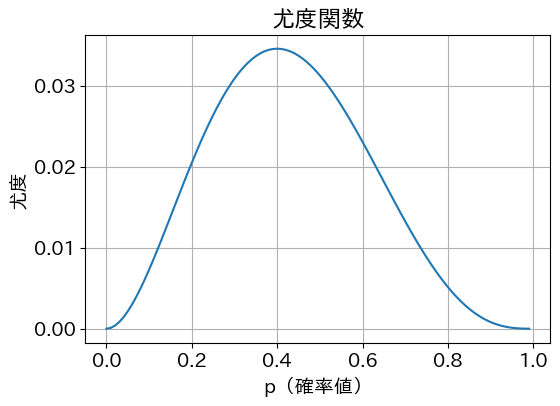

In [3]:
# 尤度関数のグラフ
def lh(p):
  return p ** 2 * (1 - p) ** 3

# グラフ描画用x座標の定義
# 0から1まで0.01刻み
p = np.arange(0, 1, 0.01)

# グラフの描画
plt.rcParams['figure.figsize'] = (6,4)
plt.plot(p, lh(p), label='尤度関数')
plt.xlabel('p（確率値）')
plt.ylabel('尤度')
plt.title('尤度関数')

- 改めて、最尤推定は尤度関数の値が最大になるパラメータpの値を求める手法
  - 上記の簡単な数式の場合、微分計算で解析的に解けるが、勾配降下法で解く。

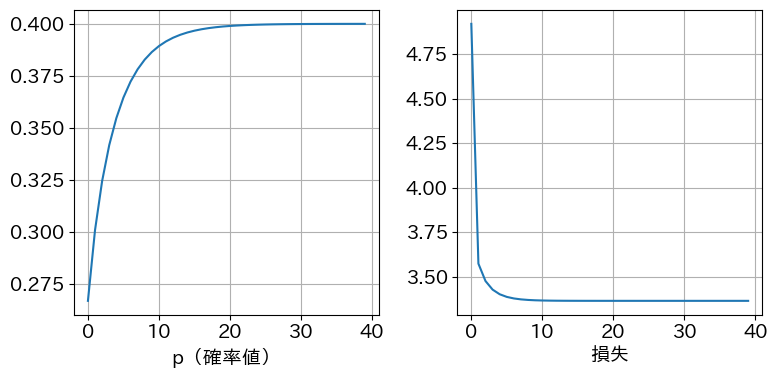

In [6]:
# 最尤推定の繰り返し計算
import torch # 確率pの最適化を行う微分計算や、勾配降下法を行うためのライブラリ

def log_lh(p): # 対数尤度関数
  return ( 2 * torch.log(p) + 3 * torch.log(1 - p) )

num_epochs = 40 # 繰り返し回数
lr = 0.01 # 学習率

# パラメータの初期値( p = 0.1 )
# requires_grad = TrueでPytorchはpの勾配を自動で追跡し、計算可能にする（勾配降下法による最適化に必須）
p  = torch.tensor(0.1, dtype = torch.float32, requires_grad=True)

#(エポック数、確率値、損失)のログを格納する変数
logs = np.zeros((0,3))

for epoch in range(num_epochs):
  loss = -log_lh(p) # 損失計算
  loss.backward() # PyTorchの自動微分機能を使い、損失関数に対する p の勾配を計算
   # 勾配は、計算グラフ上で 勾配を追跡するように設定されたテンソル（requires_grad=True）に対して計算
   # パラメータ p に対して requires_grad=True が設定されているため、loss.backward() を実行すると、p に対する勾配が計算されます。
   # その勾配は p.grad に格納
  with torch.no_grad(): # 勾配の追跡を停止し、パラメータ p を更新
    p -= lr * p.grad
    p.grad.zero_()
  log = np.array([epoch, p.item(), loss.item()]).reshape(1,-1)
  logs = np.vstack((logs, log)) # 記録したデータを logs に保存

# 上のプログラムでは尤度関数の代わりにその対数を取った対数尤度関数を用い、
# さらにそのマイナスを取った値を損失として繰り返し処理での微分計算対象としている。
# 計算の途中経過は全て変数logsに保存されています。

plt.rcParams['figure.figsize'] = (8,4)
fig, axes = plt.subplots(1, 2)
axes[0].plot(logs[:,0], logs[:,1])
axes[0].set_xlabel('p（確率値）')
axes[1].plot(logs[:,0], logs[:,2])
axes[1].set_xlabel('損失')

plt.tight_layout()
plt.show()






- 結果として、
  - 0.4の確率値が繰り返し計算で導出されている。
- 今回の問題は、求めるパラメータがp一つだけというとてもシンプルな問題。
- 確率値 p を求める問題と、線形回帰で（w_0 , w_1）を求める問題の間には、推定するパラメータをどう決定するかという共通点があります
  - パラメータを
  $$
    y = w_0 + w_1 x
  $$
  という一次関数の傾きと定数に取り替えると、線形単回帰になる。

- 線形単回帰の問題に最尤推定を適用すると、最適なパラメータの組み（w_0 , w_1）が求まる。
  - これが通常の機械学習の裏でやっている処理

- 同じ線形回帰の問題に対してベイズ推論を適用することも可能。
  - この場合、パラメータ（w_0 , w_1）がそれぞれ、確率分布として求められることになる

In [15]:
print(np.array([epoch, p.item(), loss.item()]).reshape(1,-1))
print(np.array([epoch, p.item(), loss.item()]).reshape(3,-1))
print(np.array([epoch, p.item(), loss.item()]))

[[39.000  0.400  3.365]]
[[39.000]
 [ 0.400]
 [ 3.365]]
[39.000  0.400  3.365]
